In [74]:
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs.wcsapi import SlicedLowLevelWCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.visualization.wcsaxes.frame import EllipticalFrame
import pywt
import numpy
import math
from scipy.stats import poisson
from scipy.stats import ncx2

In [2]:
data_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_ccube.fits')
cmap_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_cmap.fits')
model_file = get_pkg_data_filename('allsky_counts_model.fits')
diffuse_file = get_pkg_data_filename('diffuse_only.fits')
point_file = get_pkg_data_filename('point_only.fits')
exp_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_expcube1.fits')

In [3]:
data_hdu = fits.open(data_file)[0]
cmap_hdu = fits.open(cmap_file)[0]
model_hdu = fits.open(model_file)[2]
exp_hdu = fits.open(exp_file)[0]

In [4]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [5]:
plt.rcParams['figure.dpi'] = 300

In [43]:
count_data = fits.getdata(data_file, ext=0)[0]
cmap_data = fits.getdata(cmap_file, ext=0)
model_expected = fits.getdata(model_file, ext=0)
#model_data = numpy.vectorize(poisson.rvs)(model_expected)
diffuse_data = fits.getdata(diffuse_file, ext=0)
point_data = fits.getdata(point_file, ext=0)
exp_data = fits.getdata(exp_file, ext=0)[1]
model_norm = model_data - numpy.min(model_data)

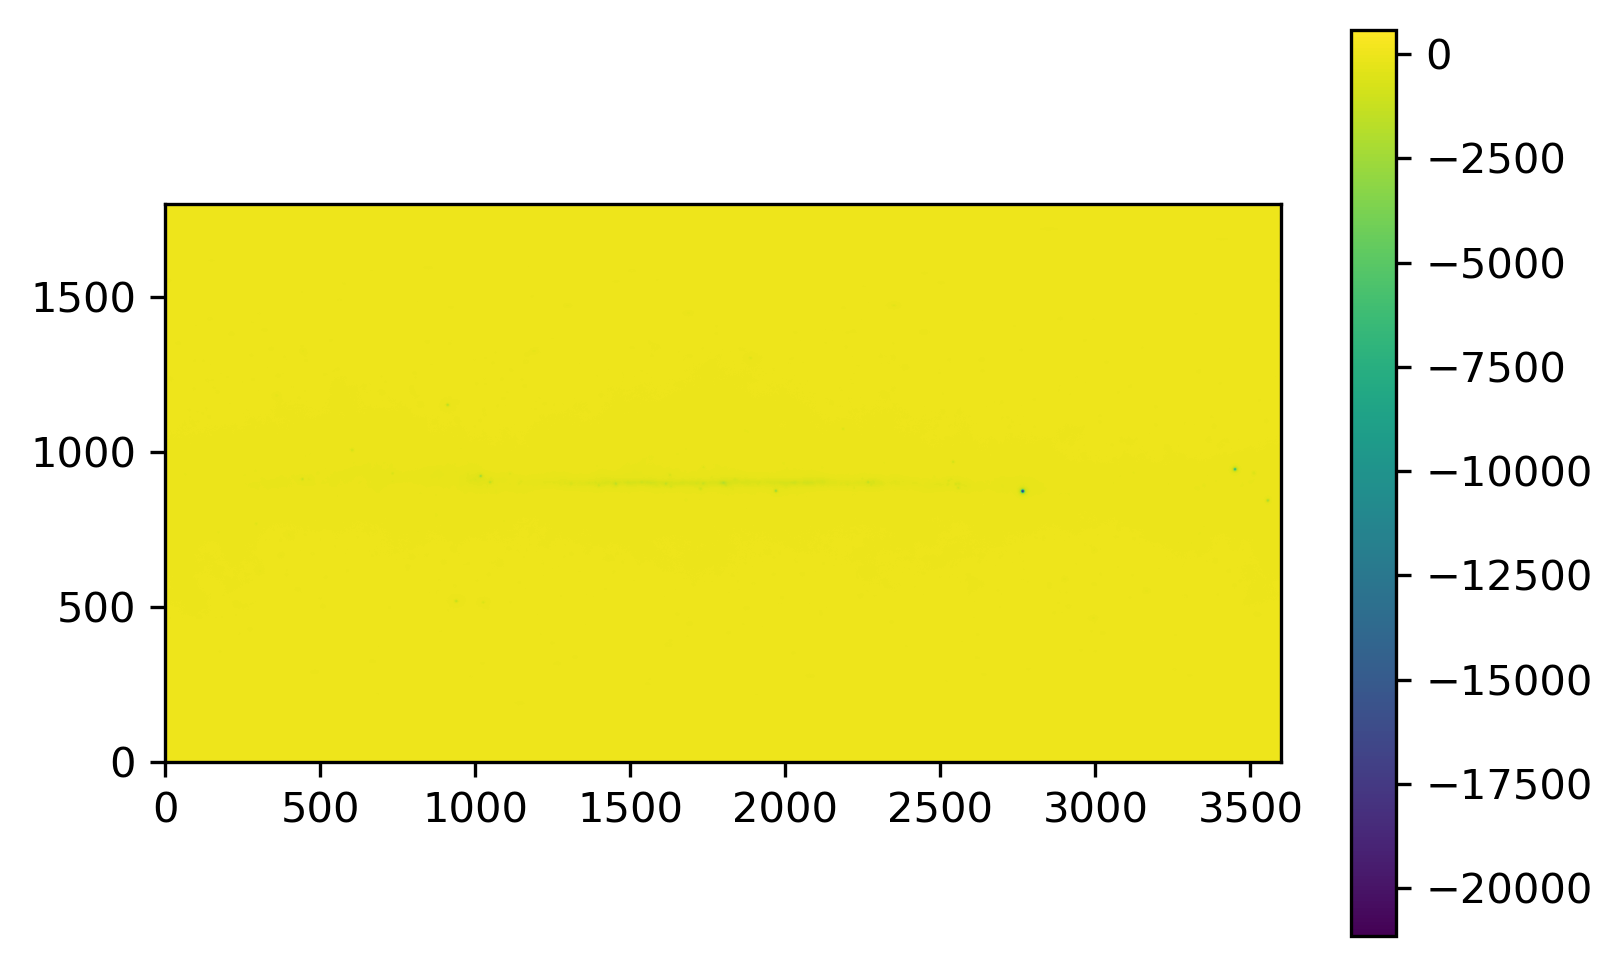

In [49]:
diff = plt.imshow(numpy.subtract(count_data, model_data), origin='lower', cmap=plt.cm.viridis)
#diff = plt.imshow(model_data, origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
plt.colorbar(diff)

In [8]:
print(numpy.max(count_data), numpy.max(model_data))
print(numpy.min(count_data), numpy.min(model_data))
print(numpy.mean(count_data), numpy.mean(model_data))
print(numpy.max(model_norm), numpy.min(model_norm))
print(numpy.max(exp_data))

32031 48166.207
0 0.0016366403
5.025956790123457 20.96125
48166.207 0.0
715351100000.0


In [9]:
def index_sphere(arr, row, col):
    h, w = numpy.shape(arr)
    wq, wr = divmod(col, w)
    hq, hr = divmod(row, h)
    if (hq % 2 == 0):
      return (hr, wr)
    else:
        return (h - hr - 1, (wr + w // 2) % w)
index_sphere(count_data, 1800, 1799)

(1799, 3599)

In [10]:
def sphere_row(arr, row):
    h, w = numpy.shape(arr)
    r = row
    hq, hr = divmod(r, h)
    if (hq % 2 == 0):
        shift = round(-w / 2) + 1 if row < 0 else 0
        print(r, hq, hr, h - hr - 1, shift)
        a = numpy.roll(arr[hr, :], shift)
        return a
    else:
        shift = round(w / 2) if row >= 0 else 0
        print(r, hq, hr, h - hr - 1, shift)
        a = numpy.roll(arr[h - hr - 1, :], shift)
        #print(arr[h - hr - 1, :])
        #print(a)
        return a

In [11]:
def roll_sphere(arr, lat_roll, lon_roll):
    rows, cols = arr.shape
    #rolled = numpy.empty(arr.shape)
    #for row in range(rows):
    #    rolled[row,:] = sphere_row(numpy.roll(arr, lon_roll, 1), row - lat_roll)
    rolled = numpy.roll(arr, lon_roll, 1)
    rolled = numpy.roll(rolled, lat_roll, 0)
    return rolled

In [22]:
def spherify(arr):
    rows, cols = arr.shape
    spharr = numpy.vstack((arr, numpy.flipud(numpy.roll(arr, cols // 2, 1))))
    return spharr

def unspherify(spharr):
    rows, cols = spharr.shape
    return spharr[0:rows//2, :]

def haar_vals(J, j, arr):
    s = 2**(J - j - 1)
    xx = arr
    xr = roll_sphere(arr, 0, s)
    dx = roll_sphere(arr, s, 0)
    dr = roll_sphere(arr, s, s)
    return (xx, xr, dx, dr)

In [13]:
def haar_sums_j(J, j, arr):
    xx, xr, dx, dr = haar_vals(J, j, arr)
    h1 = numpy.add(xx, dx)
    h2 = numpy.add(xr, dr)
    v1 = numpy.add(xx, xr)
    v2 = numpy.add(dx, dr)
    d1 = numpy.add(xx, dr)
    d2 = numpy.add(xr, dx)
    return ((h1, h2), (v1, v2), (d1, d2))

def haar_1(sums):
    (h1, h2), (v1, v2), (d1, d2) = sums
    a = numpy.add(h1, h2) / 2
    h = numpy.subtract(h1, h2) / 2
    v = numpy.subtract(v1, v2) / 2
    d = numpy.subtract(d1, d2) / 2
    return (a, h, v, d)

def haar(arr, jmin=1):
    a = spherify(arr)
    rows, cols = a.shape
    J = int(math.ceil(math.log(max(rows, cols), 2)))
    hs = []
    vs = []
    ds = []
    for j in range(J-1, jmin-1, -1):
        sums = haar_sums_j(J, j, a)
        a, h, v, d = haar_1(sums)
        hs.append(h)
        vs.append(v)
        ds.append(d)
    return a, hs, vs, ds


In [121]:
cdf = numpy.vectorize(ncx2.cdf)
sf = numpy.vectorize(ncx2.sf)
def threshold_mask(J, j, alpha, d_obs, d, mu1, mu2):
    mu1_2 = 2*mu1
    mu2_2 = 2*mu2
    n_1a = (d_obs >= d) & (d_obs > 0)
    n_1b = (d_obs >= d) & (d_obs <= 0)
    n_2a = (d_obs < d) & (d_obs >= 0)
    n_2b = (d_obs < d) & (d_obs < 0)
    df_nominal = 2**(J - j + 1) * d_obs
    df_1a = df_nominal[n_1a]
    df_1b = numpy.abs(df_nominal[n_1b] - 2)
    df_2a = df_nominal[n_2a] + 2
    df_2b = numpy.abs(df_nominal[n_2b])
    p = numpy.empty(d_obs.shape)
    p[n_1a] = cdf(mu1_2[n_1a], df_1a, mu2_2[n_1a])
    p[n_1b] = sf(mu2_2[n_1b], df_1b, mu1_2[n_1b])
    p[n_2a] = sf(mu1_2[n_2a], df_2a, mu2_2[n_2a])
    p[n_2b] = cdf(mu2_2[n_2b], df_2b, mu1_2[n_2b])
    return p < alpha/2

def haar_threshold(counts, model, alpha, jmin=1):
    a_counts = spherify(counts)
    a_model = spherify(model)
    rows, cols = a_counts.shape
    J = int(math.ceil(math.log(max(rows, cols), 2)))
    hs = []
    vs = []
    ds = []
    for j in range(J-1, jmin-1, -1):
        sums_counts = haar_sums_j(J, j, a_counts)
        a_counts, h_counts, v_counts, d_counts = haar_1(sums_counts)
        sums_model = haar_sums_j(J, j, a_model)
        a_model, h_model, v_model, d_model = haar_1(sums_model)
        ap = numpy.vectorize(poisson.cdf)(a_counts, a_model) < alpha/2
        a_model[ap] = a_counts[ap]
        (h1, h2), (v1, v2), (d1, d2) = sums_model
        hp = threshold_mask(J, j, alpha, h_counts, h_model, h1, h2)
        h_model[hp] = h_counts[hp]
        vp = threshold_mask(J, j, alpha, v_counts, v_model, v1, v2)
        v_model[vp] = v_counts[vp]
        dp = threshold_mask(J, j, alpha, d_counts, d_model, d1, d2)
        d_model[dp] = d_counts[dp]
        hs.append(h_model)
        vs.append(v_model)
        ds.append(d_model)
    return a_model, hs, vs, ds

In [20]:
def inv_haar_j(J, j, a, h, v, d):
    N = 2**J
    s = 2**(J - j - 1)
    rows, cols = a.shape
    sh = (rows, cols)
    arr = numpy.empty(sh, float)
    ah = numpy.add(a,h)
    av = numpy.add(a,v)
    ad = numpy.add(a,d)
    vd = numpy.add(v,d)
    hd = numpy.add(h,d)
    hv = numpy.add(h,v)
    xx = numpy.add(ah,vd)
    xr = numpy.subtract(av,hd)
    dx = numpy.subtract(ah,vd)
    dr = numpy.subtract(ad,hv)
    spharr = (xx 
            + roll_sphere(xr, 0, -s) 
            + roll_sphere(dx, -s, 0) 
            + roll_sphere(dr, -s, -s)
           ) / 8
    return spharr

def inv_haar(a, hs, vs, ds):
    rows, cols = a.shape
    J = int(math.ceil(math.log(max(rows, cols), 2)))
    nj = len(hs)
    for i in range(nj-1, -1, -1):
        j = J - i - 1
        a = inv_haar_j(J, j, a, hs[i], vs[i], ds[i])
    return unspherify(a)

In [63]:
def zero(n):
    return numpy.zeros((n,n), float)

def checkers(n, p):
    arr = numpy.zeros((n, 2*n), float) + 2
    for row in range(n):
        rq, rr = divmod(row, p)
        row_mult = 1 if rq % 2 == 0 else -1
        for col in range(2*n):
            cq, cr = divmod(col, p)
            col_mult = 1 if cq % 2 == 0 else -1
            arr[row,col] += row_mult*col_mult
    return arr

def delta(n, row, col):
    arr = zero(n) + 1
    arr[row, col] = 2
    return arr

In [109]:
count_model = checkers(30, 8)
count_data = numpy.vectorize(poisson.rvs)(count_model)
a_model, hs_model, vs_model, ds_model = haar(count_model)

In [131]:
a, hs, vs, ds = haar_threshold(count_data, count_model, 0.01, 5)

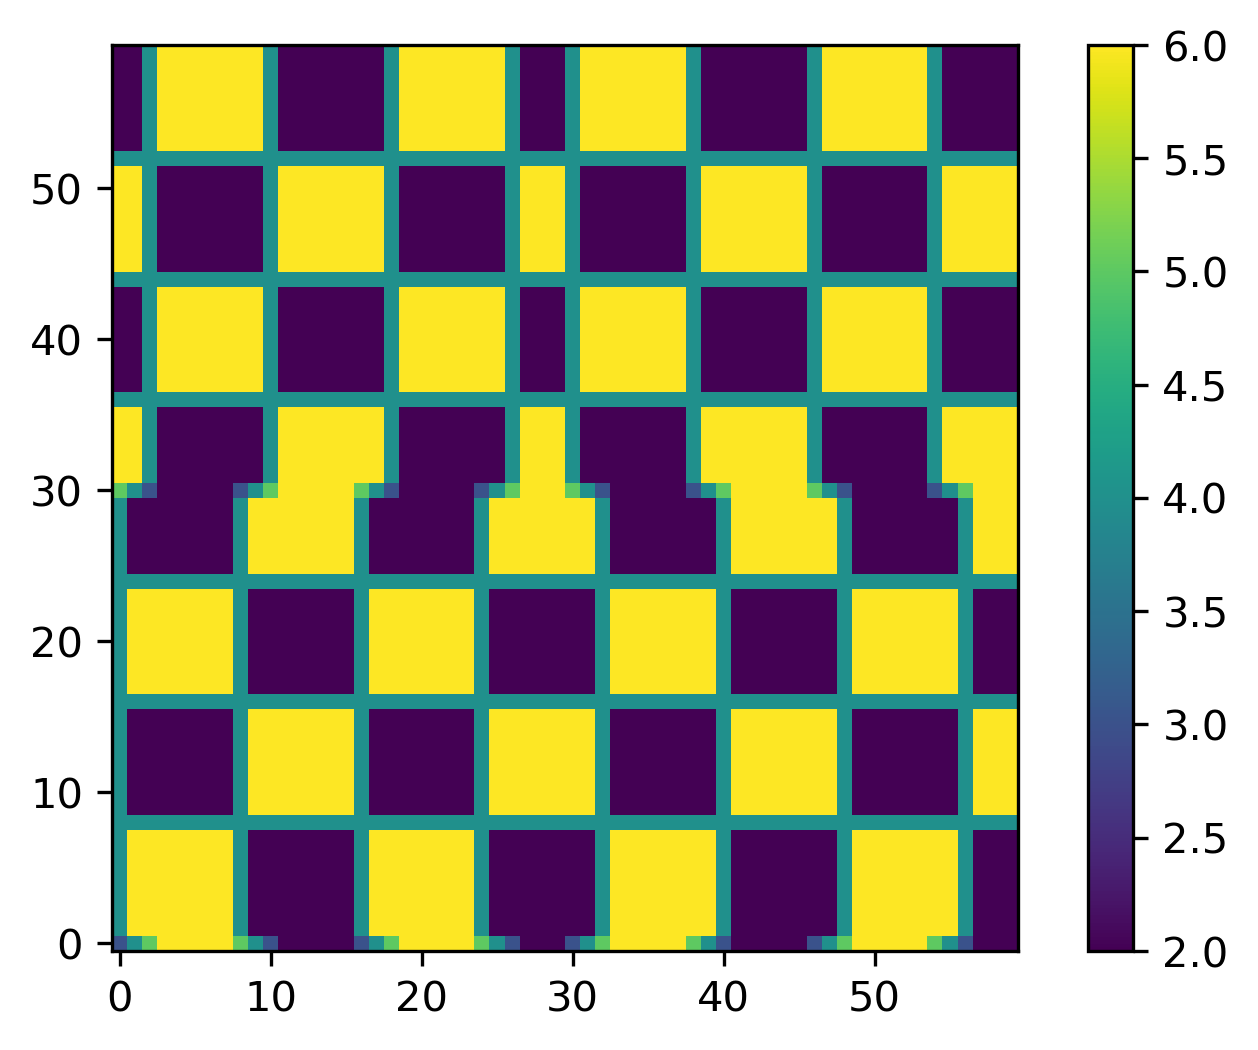

In [132]:
#foo = plt.imshow(p, origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
foo = plt.imshow(a, origin='lower', cmap=plt.cm.viridis)
plt.colorbar(foo)

In [133]:
count_rec = inv_haar(a, hs, vs, ds)
#foo = plt.imshow(count_data - count_rec, origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
#foo = plt.imshow(count_data - count_rec, origin='lower', cmap=plt.cm.viridis)
#plt.plot(count_data[1, :])
#plt.plot(count_data[900, 1700:1900])
#plt.plot(numpy.subtract(count_data, count_rec)[5, :])
#plt.plot(a[900, 1700:1900] - a_rec[899, 1700:1900])


i 0
1 6 5


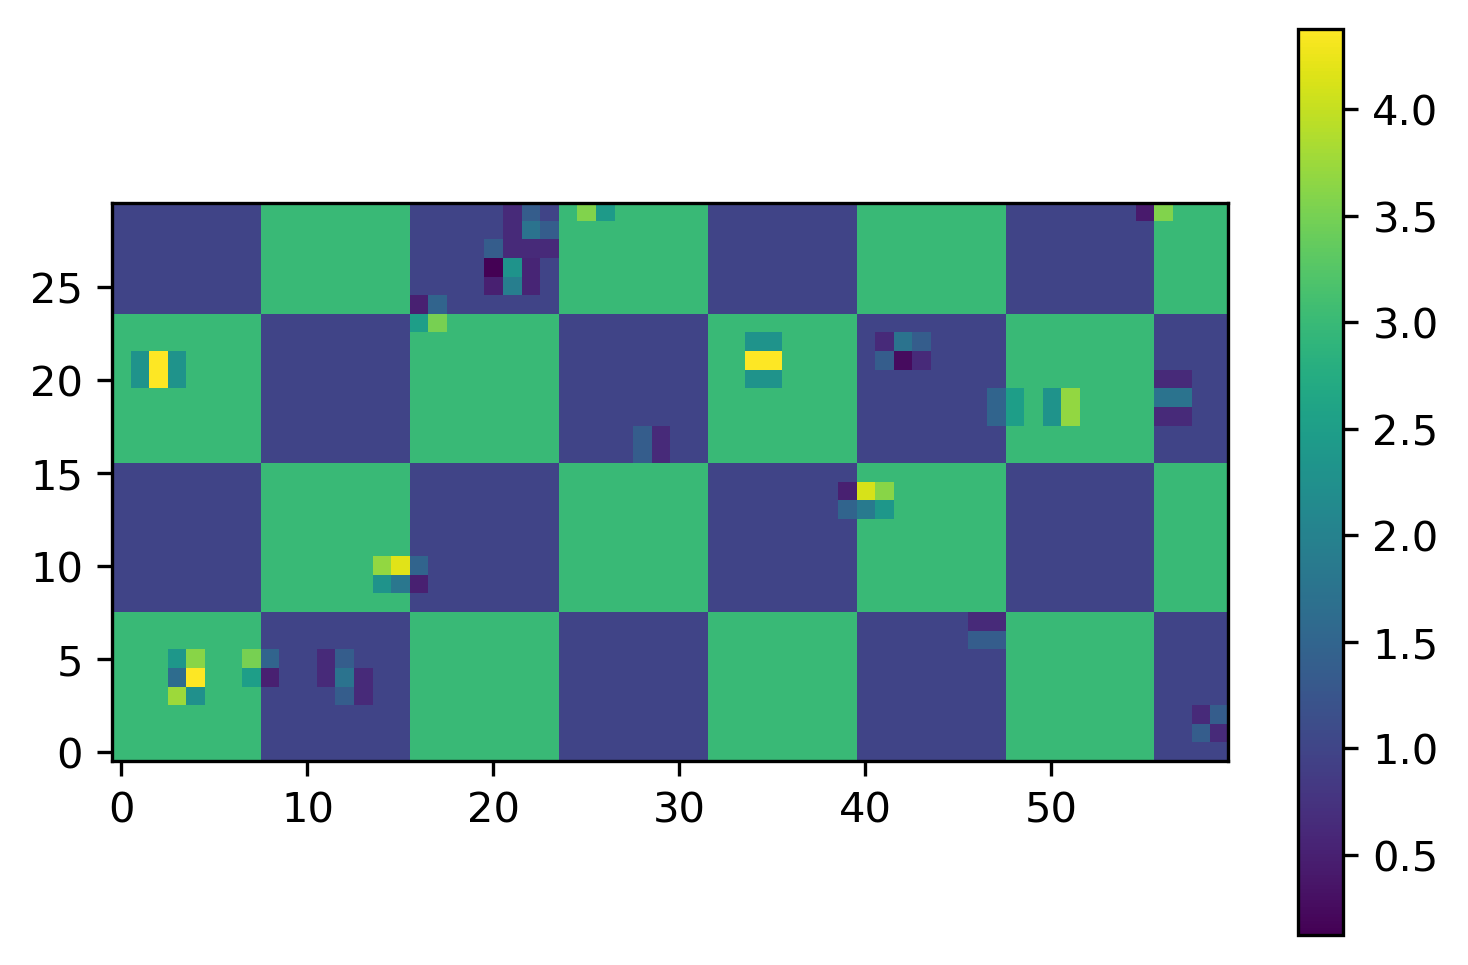

In [134]:
foo = plt.imshow(count_rec, origin='lower')
plt.colorbar(foo)
#plt.plot(numpy.subtract(count_data.astype(float), count_rec)[0, :])

In [35]:
del a, hs, vs, ds

In [62]:
print(sum(sum(count_data)))
print(sum(sum(a)))
print(sum(sum(a2)))
print(sum(sum(a_rec)))
print(sum(sum(count_rec)))
sum(sum(a))/sum(sum(count_data))

32568200
65136400.0
130272792.0
65136396.0
32568200.0


2.0

In [418]:
#foo = plt.imshow(roll_sphere(dx, -1, 0), origin='lower')
#plt.colorbar(foo)
roll_sphere(roll_sphere(im, 1, 0), -1, 0)

1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0
9 0 9 0 0
10 1 0 9 5
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
9 0 9 0 -4
0 0 0 9 0
1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [188]:
a, h, v, d = haar_j(12, 11, count_data)

In [192]:
a10, _, _, _ = haar_j(12, 10, a)
a9, _, _, _ = haar_j(12, 9, a10)
a8, _, _, _ = haar_j(12, 8, a9)
a7, _, _, _ = haar_j(12, 7, a8)
a6, _, _, _ = haar_j(12, 6, a7)
a5, _, _, _ = haar_j(12, 5, a6)
a4, _, _, _ = haar_j(12, 4, a5)
a3, _, _, _ = haar_j(12, 3, a4)
a2, _, _, _ = haar_j(12, 2, a3)
a1, _, _, _ = haar_j(12, 1, a2)

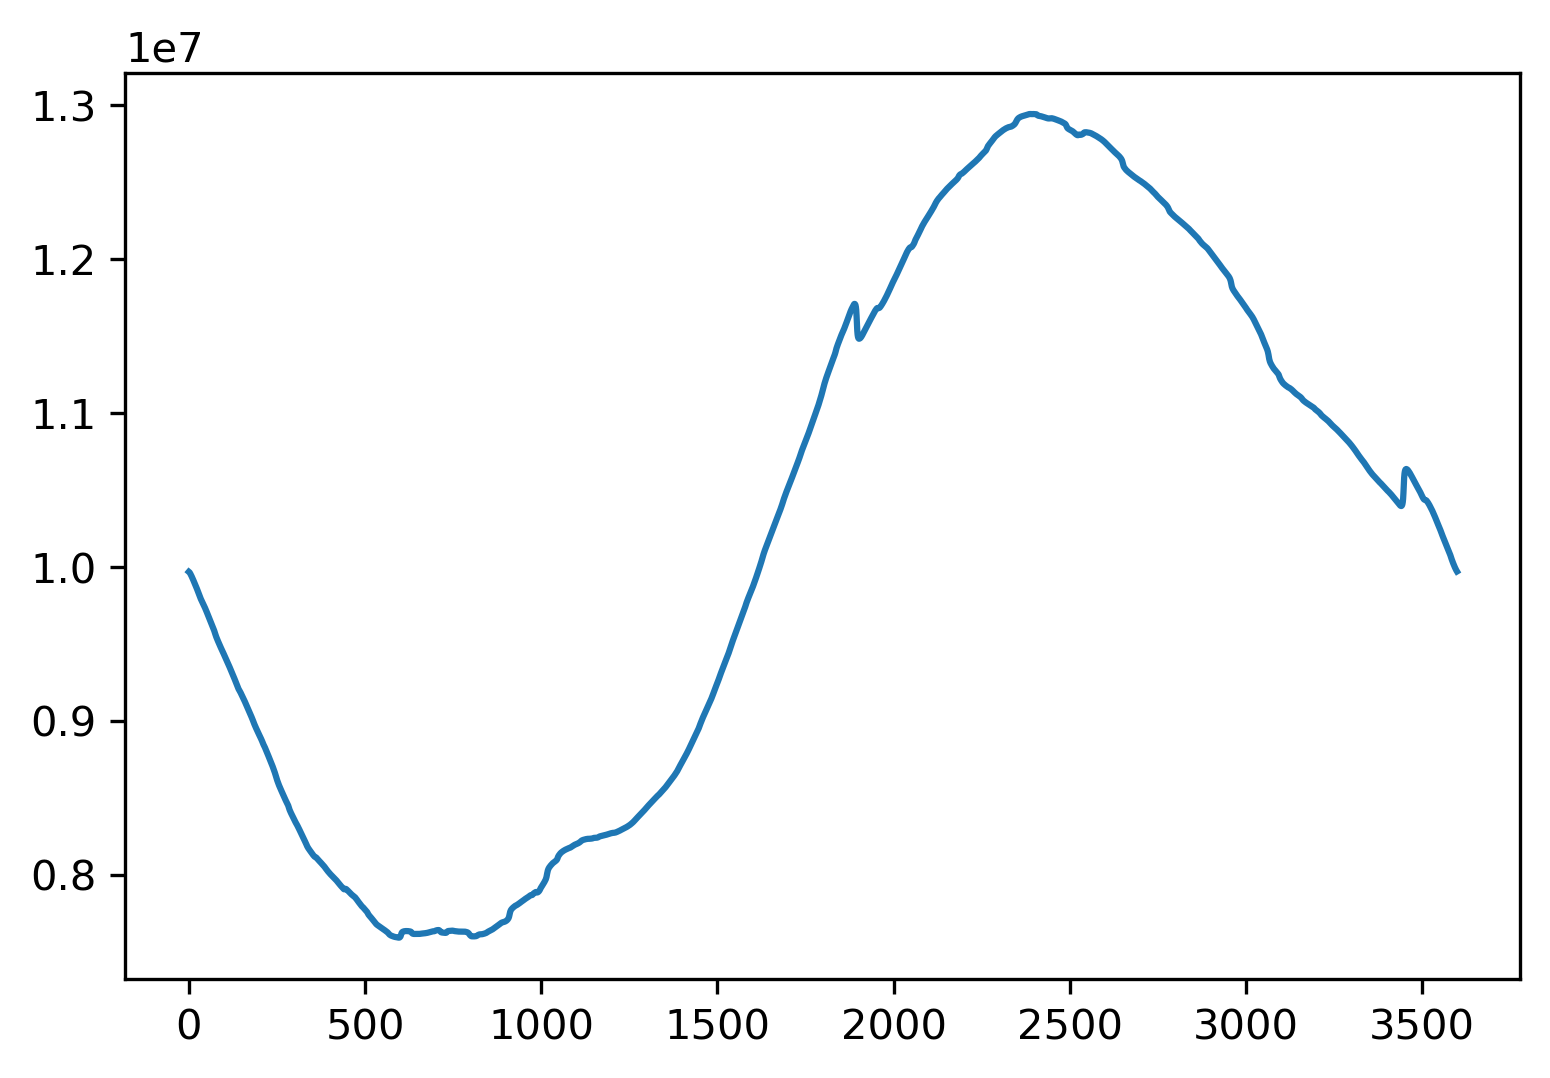

In [194]:
plt.plot(a1[900, :])

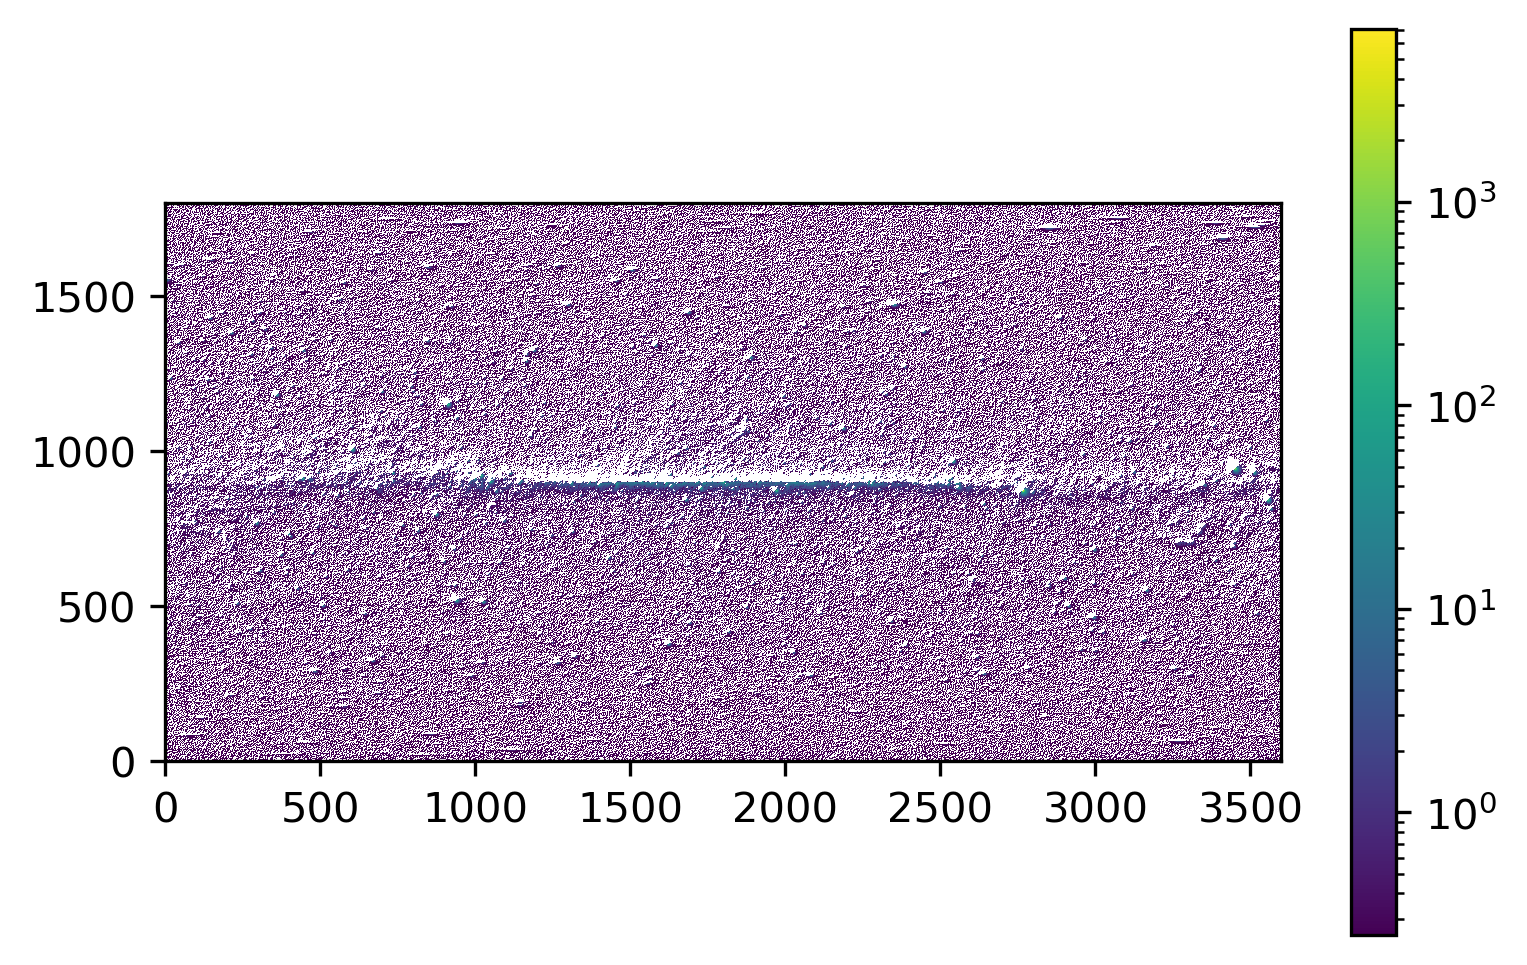

In [215]:
diff = plt.imshow(numpy.subtract(a / 4, count_data), origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
plt.colorbar(diff)

In [109]:
2**12

4096

In [16]:
ax.set_xlim(-180,180)

(-180.0, 180.0)

In [17]:
overlay = ax.get_coords_overlay('fk5')

In [18]:
overlay.grid(color='black', ls='dotted')